# Note

tokenizer
* https://github.com/google/sentencepiece: sub-word
* https://github.com/openai/tiktoken: byte

# Read

In [1]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [2]:
# print first 100 characters
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [3]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(chars)
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
65


the size of the look up table (embedding table) is 65 · 65, because we have 65 different characters.

# A Trivial Mapping (A Trivial Tokenizer)

In [4]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [5]:
print(encode("I Love You"))
print(decode(encode("I Love You")))

[21, 1, 24, 53, 60, 43, 1, 37, 53, 59]
I Love You


In [6]:
print(encode("I love you"))
print(decode(encode("I love you")))

[21, 1, 50, 53, 60, 43, 1, 63, 53, 59]
I love you


# Mapping via PyTorch

In [7]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [8]:
print(decode([18, 47]))

Fi


In [9]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [10]:
# 
block_size = 8
train_data[:block_size+1]

# Let's now create a small example to see how the training data will look like
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [11]:
# Let's now create a small batch of data to see how the training data will look like

torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)


inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


In [12]:
print('targets:')
print(yb.shape)
print(yb)

print('----')


targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----


In [13]:
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53, 56, 1, 58, 46] the target: 39
when input is [44, 53, 56, 1, 58, 46, 39] the target: 58
when input is [44, 53, 56, 1, 58, 46, 39, 58] the target: 1
when input is [52] the target: 58
when input is [52, 58] the target: 1
when input is [52, 58, 1] the target: 58
when input is [52, 58, 1, 58] the target: 46
when input is [52, 58, 1, 58, 46] the target: 39
when input is [52, 58, 1, 58, 46, 39] the t

# Bigram

In [14]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [15]:
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)

In [16]:
print(xb)
print(yb)
print(logits) # (B, T, C)
print(loss)

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
tensor([[-1.5101, -0.0948,  1.0927,  ..., -0.6126, -0.6597,  0.7624],
        [ 0.3323, -0.0872, -0.7470,  ..., -0.6716, -0.9572, -0.9594],
        [ 0.2475, -0.6349, -1.2909,  ...,  1.3064, -0.2256, -1.8305],
        ...,
        [-2.1910, -0.7574,  1.9656,  ..., -0.3580,  0.8585, -0.6161],
        [ 0.5978, -0.0514, -0.0646,  ..., -1.4649, -2.0555,  1.8275],
        [-0.6787,  0.8662, -1.6433,  ...,  2.3671, -0.7775, -0.2586]],
       grad_fn=<ViewBackward0>)
tensor(4.8786, grad_fn=<NllLossBackward0>)


In [17]:
torch.manual_seed(1337)  # Set seed before generation for consistent results
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=1)[0].tolist()))


J


In [18]:
torch.manual_seed(1337)  # Set seed before generation for consistent results
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=10)[0].tolist()))


JFEszcPU;z


In [19]:
torch.manual_seed(1337)  # Set seed before generation for consistent results
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


JFEszcPU;zRqv$.&jF.CK?ERSP!rqZ-B&CXx?oi-GSA'A-QK
Y$GYGloXaWgQlZeCj?lyIWlabjxTOW:ChR; fQ'MgvmEPZ!
J.P


# Train

In [20]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3) # m.parameters() gives the optimizer access to all trainable weights in the model

In [21]:
batch_size = 32 # how many independent sequences will we process in parallel?

for steps in range(10000):
    # sample a batch of data
    xb, yb = get_batch('train')
    # evaluate the loss
    logits, loss = m(xb, yb)
    # backpropagate the gradients
    optimizer.zero_grad(set_to_none=True) # zero out the gradients
    loss.backward() # backpropagate the loss
    optimizer.step() # update the parameters 

print(f"loss: {loss.item():.4f} \n", end='')

loss: 2.4716 


In [22]:
torch.manual_seed(1337)  # Set seed before generation for consistent results
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


JOHulche; h co.
CouCKI:
LABe y, crd bo tarreror thindrariathitot.
Thathest
INOWe hin t 's ve het
LEL


# Attention

In GPT, we use previous tokens to predict the next token, and the information (when we are predicting the current token) could only come from the previous tokens, not future tokens. 

In [23]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [ ]:
# version 1: for loop
# We want x[b,t] = mean_{i<=t} x[b,i] (the mean of all previous tokens in the sequence)
xbow = torch.zeros((B,T,C)) # bow: bag of words
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)

In [25]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (T, T) @ (B, T, C) ----> (B, T, C), Broadcast

In [ ]:
# version 2(v2): Using matrix multiply, but without broadcasting
xbow2_v2 = torch.zeros_like(xbow)  # (B, T, C)
# For each batch b:
for b in range(B):
    xbow2_v2[b] = wei @ x[b]  # (T, T) @ (T, C) -> (T, C)

## Why Not Equal?

In [30]:
print("Cell 36 - xbow2 vs xbow2_v2:")
print(f"  allclose: {torch.allclose(xbow2, xbow2_v2)}")
print(f"  max diff: {torch.max(torch.abs(xbow2 - xbow2_v2))}")

print("Cell 37 - xbow vs xbow2_v2:")  
print(f"  allclose: {torch.allclose(xbow, xbow2_v2)}")
print(f"  max diff: {torch.max(torch.abs(xbow - xbow2_v2))}")

print("Cell 38 - xbow vs xbow2:")
print(f"  allclose: {torch.allclose(xbow, xbow2)}")
print(f"  max diff: {torch.max(torch.abs(xbow - xbow2))}")

Cell 36 - xbow2 vs xbow2_v2:
  allclose: True
  max diff: 1.1920928955078125e-07
Cell 37 - xbow vs xbow2_v2:
  allclose: True
  max diff: 1.1920928955078125e-07
Cell 38 - xbow vs xbow2:
  allclose: False
  max diff: 3.236345946788788e-08


In [36]:
temp = torch.isclose(xbow, xbow2)
temp

tensor([[[ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True, False],
         [ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True]]])

In [37]:
# Find positions where elements are False
false_positions = torch.where(temp == False)
print("Positions where temp is False:")
print(false_positions)

Positions where temp is False:
(tensor([1]), tensor([5]), tensor([1]))


In [ ]:
# Count how many are False
num_false = torch.sum(temp == False)
print(f"Number of False elements: {num_false}")

Number of False elements: 1


In [52]:
print("Value at False positions:")
print(xbow[false_positions])
print(xbow2[false_positions])
print(xbow2_v2[false_positions])

print("Differences at False positions:")
print((xbow - xbow2)[false_positions])
print((xbow2_v2 - xbow2)[false_positions])
print((xbow - xbow2_v2)[false_positions])

Value at False positions:
tensor([0.0020])
tensor([0.0020])
tensor([0.0020])
Differences at False positions:
tensor([3.2363e-08])
tensor([2.2352e-08])
tensor([1.0012e-08])


In [31]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [32]:
wei = torch.zeros((T,T))
wei

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [33]:
wei = wei.masked_fill(tril == 0, float('-inf'))
wei

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In the end, we use ver 3, because the -inf here means that "the information (when we are predicting the current token) could only come from the previous tokens, not future tokens. "

In [34]:
wei = F.softmax(wei, dim=-1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [35]:
xbow3 = wei @ x
print(f"  allclose: {torch.allclose(xbow, xbow3)}")
print(f"  max diff: {torch.max(torch.abs(xbow - xbow3))}")

  allclose: False
  max diff: 3.236345946788788e-08


Query: What Am I Looking For?

Key: What Do I Contain?

$Q \cdot K$: The Cor-relation Between Each Pair of Tokens.

---

Value (V): "What information do I actually contribute?"

$Q \cdot K \cdot V$: Uses those attention weights to aggregate the actual information from Values

---

nn: Neural Network.

functional: contains functions without paras, like relu/tanh/sigmoid or cross-entropy/MSE.

nn.Linear: Learn a Matrix.

> When you call key(x):
> 
> output = x @ W.T + b  # (if bias=True)
> 
> or
> 
> output = x @ W.T      # (if bias=False)
>

---

We use Kaiming Uniform Init for Key:

```
key = nn.Linear(C, head_size, bias=False)
# C = 32, head_size = 16
# Weight matrix shape: (16, 32)

std = math.sqrt(1.0 / 32) ≈ 0.177
# Each weight is randomly sampled from:
# Uniform(-0.177 * sqrt(3), 0.177 * sqrt(3))
# Which is approximately: Uniform(-0.306, 0.306)
```

In [ ]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False) # value is the same as key and query, but it will be used to compute the output
k = key(x)   # (B, T, 16) # Applies the transformation: x @ W_k.T
q = query(x) # (B, T, 16) # Applies the transformation: x @ W_q.T
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
# wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) # mask out future tokens (GPT-Style)
wei = F.softmax(wei, dim=-1) # normalize the weights

# out = wei @ x (Naive, without value)
v = value(x)
out = wei @ v

out.shape

torch.Size([4, 8, 16])

In [56]:
# print shape of key
print(k.shape)  # (B, T, head_size)

torch.Size([4, 8, 16])


In [55]:
wei

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
         [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
         [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
         [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1687, 0.8313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2477, 0.0514, 0.7008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4410, 0.0957, 0.3747, 0.0887, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0069, 0.0456, 0.0300, 0.7748, 0.1427, 0.0000, 0.0000, 0.0000],
         [0.0660, 0.089

In [57]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

Note:

1. You can think attention like a math graph, which is bi-directed.
2. BERT simply does not need the -inf mask.
3. Different batches are processed independently.
4. x produces Q, K, and V, so we call $QKV$ self-attention. While in BERT, Q, K, and V come from different vector, so we call it cross-attention.

## Why divided by $\sqrt{d}$ ?

In [63]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [64]:
k.var()

tensor(0.9006)

In [65]:
q.var()

tensor(1.0037)

In [66]:
wei.var()

tensor(0.9957)

# ResNet

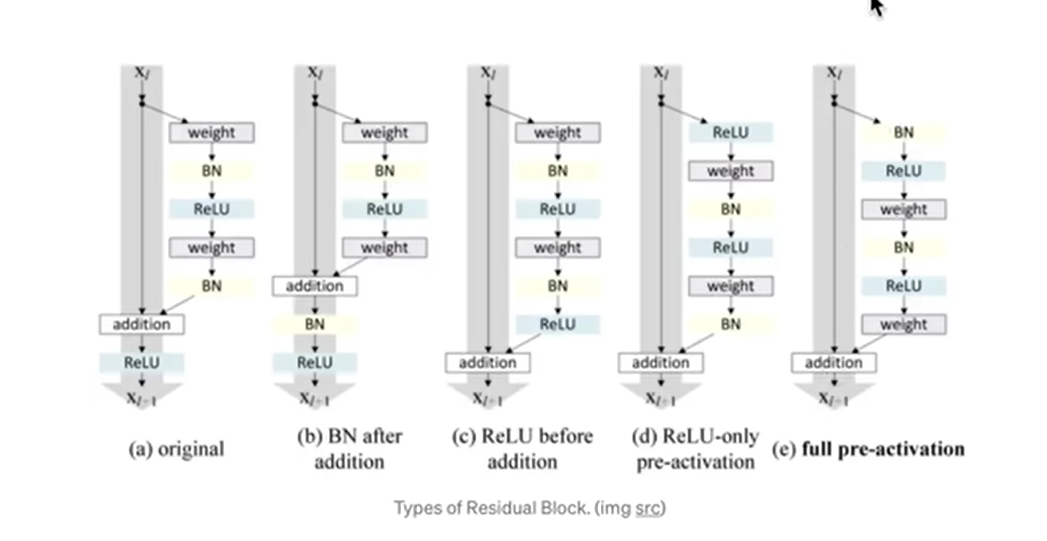

# Layer Normalization